## Validação dos pseudo-neagtivos com Random Forest

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import shap
import numpy
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('dataset_final_para_modelo_1_4.csv', decimal=",")
df

latitude  longitude        data  dia_semana  mes  is_weekend  hora  \
0     -22.350470 -49.044849  2023-07-05           2    7           0    17   
1     -22.348728 -49.062482  2023-07-24           0    7           0    17   
2     -22.368592 -49.061826  2024-06-30           6    6           1    21   
3     -22.323114 -49.052350  2025-03-29           5    3           1    21   
4     -22.312688 -49.069385  2023-10-25           2   10           0    18   
...          ...        ...         ...         ...  ...         ...   ...   
40940 -22.304407 -49.046694  2025-04-26           5    4           1     9   
40941 -22.312328 -49.027581  2023-01-06           4    1           0     2   
40942 -22.301454 -49.093404  2024-04-26           4    4           0     6   
40943 -22.328793 -49.089578  2022-01-22           5    1           1    10   
40944 -22.326635 -49.124658  2023-11-07           1   11           0     0   

       Sinistro  Chuva  tipo_via_num  tp_veiculo_bicicleta  \
0             0      0           1.0                     0   
1             1      0           0.0                     0   
2             0      0           0.0                     0   
3             0      0           1.0                     0   
4             0      0           0.0                     0   
...         ...    ...           ...                   ...   
40940         0      1           0.0                     0   
40941         0      0           0.0                     0   
40942         0      0           0.0                     0   
40943         0      0           0.0                     0   
40944         0      0           0.0                     0   

       tp_veiculo_caminhao  tp_veiculo_motocicleta  tp_veiculo_nao_disponivel  \
0                        0                       0                          0   
1                        0                       0                          0   
2                        0                       0                          0   
3                        0                       0                          0   
4                        0                       0                          0   
...                    ...                     ...                        ...   
40940                    0                       0                          0   
40941                    0                       0                          0   
40942                    0                       0                          0   
40943                    0                       0                          0   
40944                    0                       0                          0   

       tp_veiculo_onibus  tp_veiculo_outros  tp_veiculo_automovel  
0                      0                  0                     0  
1                      0                  0                     2  
2                      0                  0                     0  
3                      0                  0                     0  
4                      0                  0                     0  
...                  ...                ...                   ...  
40940                  0                  0                     0  
40941                  0                  0                     0  
40942                  0                  0                     0  
40943                  0                  0                     0  
40944                  0                  0                     0  

[40945 rows x 17 columns]

### Separação de Features (X) e Alvo (y)

In [3]:
X = df.drop(columns=['Sinistro', 'data']) 

y = df['Sinistro']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=8, stratify=y
)

print(f"Tamanho do conjunto de treino: {X_train.shape}")
print(f"Tamanho do conjunto de teste: {X_test.shape}")

Tamanho do conjunto de treino: (28661, 15)
Tamanho do conjunto de teste: (12284, 15)


### Treinar o modelo

In [4]:
model = RandomForestClassifier(
    random_state=8,
    class_weight='balanced',
    )

model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=8)

### Fazer previsões e avaliar as métricas


--- Matriz de Confusão ---


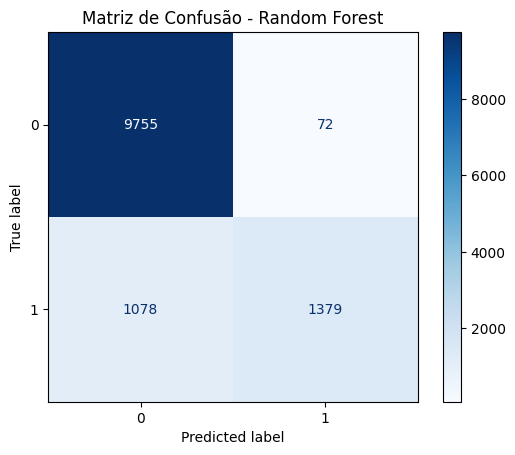


--- Relatório de Classificação ---
              precision    recall  f1-score   support

           0       0.90      0.99      0.94      9827
           1       0.95      0.56      0.71      2457

    accuracy                           0.91     12284
   macro avg       0.93      0.78      0.83     12284
weighted avg       0.91      0.91      0.90     12284

--- AUC (Área Sob a Curva ROC) ---
0.8777


In [5]:
# O modelo faz as previsões nos dados de teste
y_pred = model.predict(X_test)


print("\n--- Matriz de Confusão ---")
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusão - Random Forest")
plt.show()

print("\n--- Relatório de Classificação ---")
print(classification_report(y_test, y_pred))

y_prob = model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_prob)
print(f"--- AUC (Área Sob a Curva ROC) ---")
print(f"{auc:.4f}")

### SHAP (Shapley Additive exPlanations)

PermutationExplainer explainer: 12285it [17:01:34,  4.99s/it]                                   
C:\Users\pirsp\AppData\Local\Temp\ipykernel_21692\1063239192.py:6: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[:, :, 1], X_test, max_display=15, show=True)


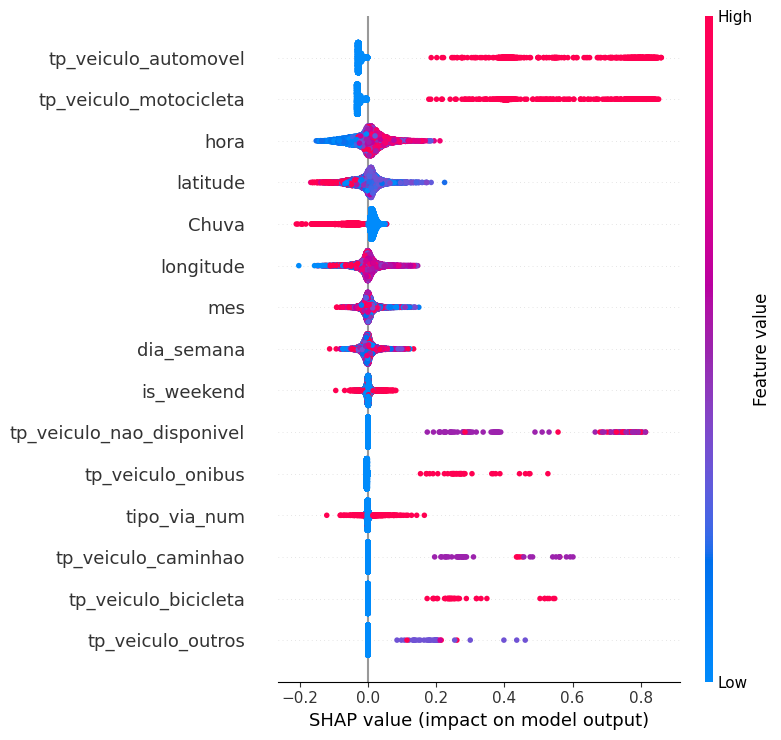

C:\Users\pirsp\AppData\Local\Temp\ipykernel_21692\1063239192.py:9: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[:, :, 1], X_test, plot_type="bar", max_display=15, show=True)


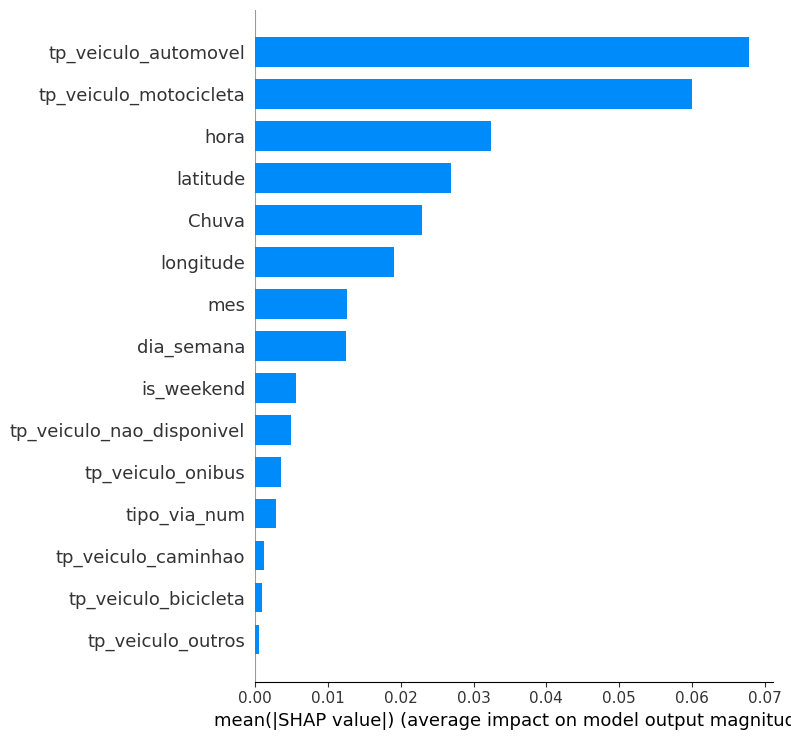

In [6]:
explainer = shap.Explainer(model.predict_proba, X_train)
shap_values = explainer(X_test)

# Gráfico de Resumo Detalhado (Beeswarm) para a classe 1
# Usamos max_display para mostrar as 15 features mais importantes
shap.summary_plot(shap_values[:, :, 1], X_test, max_display=15, show=True)

# Gráfico de Barras (Importância Global) para a classe 1
shap.summary_plot(shap_values[:, :, 1], X_test, plot_type="bar", max_display=15, show=True)